# Introduction to Data Science
<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
Contact author(s): Becky Nevin, Brian Nord<br>
Last verified to run: 2025-05-06 <br>
LSST Science Pipelines version: Weekly 2025_09 <br>
Container size: small <br>
Targeted learning level: intermediate <br>

In [ ]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

**Description:** This notebook guides a PI through the process of using python's data science and machine learning libraries to explore data from complex ADQL queries with the TAP service. The goal is to build a predictive model to estimate missing $r-$band Kron Flux values when the other bands are available, and visualize the results and quantify the model performance.

**Skills:** Use of data science and machine learning tools such as scikit-learn, pandas, and seaborn.

**LSST Data Products:** Object, Forcedsource, and CcdVisit tables.

**Packages:** lsst.rsp, pandas, scikit-learn, seaborn

**Credits:** Developed by Becky Nevin in collaboration with Melissa Graham, Brian Nord, and the Rubin Community Science Team for DP0.2. Based on notebooks developed by Leanne Guy (TAP query) and Alex Drlica-Wagner and Melissa Graham (Butler query).
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

# 1. Introduction

This notebook provides an intermediate-level demonstration of how to use the Table Access Protocol (TAP) server and ADQL (Astronomy Data Query Language) to query and retrieve data from the DP0.2 catalogs.

TAP provides standardized access to catalog data for discovery, search, and retrieval.
Full <a href="http://www.ivoa.net/documents/TAP">documentation for TAP</a> is provided by the International Virtual Observatory Alliance (IVOA).
ADQL is similar to SQL (Structured Query Langage).
The <a href="http://www.ivoa.net/documents/latest/ADQL.html">documentation for ADQL</a> includes more information about syntax and keywords.
Note that not all ADQL functionality is supported yet in the DP0-era RSP.

**See the recommendations for TAP queries in DP0.2 tutorial 02a "Introduction to the TAP Service".**

The [documentation for Data Preview 0.2](https://dp0-2.lsst.io/) includes definitions
of the data products, descriptions of catalog contents, and ADQL recipes.

## 1.1. Package imports

Import general python packages, the Rubin TAP service utilities, and various scikit-learn utilities.

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas

from astropy import units as u
from astropy.coordinates import SkyCoord

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
import inspect
from sklearn.utils import all_estimators


from lsst.rsp import get_tap_service, retrieve_query

Set up seaborn to use a friendly palette.

In [2]:
sns.set_style("whitegrid")
palette = sns.color_palette("colorblind")
sns.set_palette(palette)

## 1.2. Define functions and parameters

Instantiate the TAP service.

In [3]:
service = get_tap_service("tap")
assert service is not None

Set the maximum number of rows to display from pandas.

In [4]:
pandas.set_option("display.max_rows", 6)

# 2. Query for Kron fluxes around extended (galaxy) objects.
The Kron flux is a measurement of the total flux (or brightness) of an astronomical object, typically a galaxy or extended source, obtained using an elliptical aperture that scales with the object's light profile. It’s designed to include most of the object’s light while minimizing background contamination.

The aperture is defined based on the Kron radius, which is calculated from the first moment of the light distribution. The resulting aperture is adaptive - it changes in size and shape depending on the morphology of the source.

Define the coordinates and radius to use for the example queries in Sections 2 and 3.

In [5]:
center_ra = 62
center_dec = -37
radius = 0.1

str_center_coords = str(center_ra) + ", " + str(center_dec)
str_radius = str(radius)

Start with the same query as used in the beginner TAP tutorial notebook 02a. Note that the extendedness flag in the $g-$band is used to select for galaxies.

In [6]:
query = "SELECT coord_ra, coord_dec, g_kronFlux, g_kronFlux_flag, "\
        "r_kronFlux, r_kronFlux_flag, i_kronFlux, i_kronFlux_flag "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1 AND g_extendedness = 1"
print(query)

SELECT coord_ra, coord_dec, g_kronFlux, g_kronFlux_flag, r_kronFlux, r_kronFlux_flag, i_kronFlux, i_kronFlux_flag FROM dp02_dc2_catalogs.Object WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 62, -37, 0.1)) = 1 AND detect_isPrimary = 1 AND g_extendedness = 1


Run the query job asynchronously.

In [7]:
job = service.submit_job(query)
job.run()
job.wait(phases=["COMPLETED", "ERROR"])
print("Job phase is", job.phase)

Job phase is COMPLETED


# 3. Explore the data using a `pandas` DataFrame object.
From the `pandas` docs:
> A DataFrame is a two-dimensional, size-mutable, heterogeneous tabular data structure with labeled axes (rows and columns).

Return the results as a `pandas` DataFrame, and then delete the query to save space.

In [8]:
results = job.fetch_result().to_table().to_pandas()
job.delete()
del query

Display `results`.

In [9]:
results

,coord_ra,coord_dec,g_kronFlux,g_kronFlux_flag,r_kronFlux,r_kronFlux_flag,i_kronFlux,i_kronFlux_flag
0,62.018897,-37.095671,71.568352,True,91.185588,True,624.454022,True
1,62.020999,-37.093227,174.729861,False,110.922305,False,52.040203,True
2,62.000430,-37.093196,131.680920,False,137.655812,False,136.174616,True
...,...,...,...,...,...,...,...,...
11561,61.950427,-36.946586,51.054369,True,175.646973,False,123.073904,True
11562,61.976752,-36.904225,199.039503,False,187.972452,False,115.825734,False
11563,61.932319,-36.941077,266.123377,False,218.853195,False,481.650950,True


In [10]:
type(results)

pandas.core.frame.DataFrame

There's a lot of options for investigating DataFrame objects. Some options are inspection- and summary-oriented, such as the `.head()`, `.tail()`, and `.describe()` attributes.

Check these out now. `.head()` and `.tail()` show the first and last five rows, respectively, but can be modified to print out a different number of rows. `.describe()` provides statistics of the distribution of values in each column, including the mean and standard deviation.

In [11]:
print(results.head())
print(results.tail(10))
print(results.describe())

    coord_ra  coord_dec  g_kronFlux  g_kronFlux_flag  r_kronFlux  \
0  62.018897 -37.095671   71.568352             True   91.185588   
1  62.020999 -37.093227  174.729861            False  110.922305   
2  62.000430 -37.093196  131.680920            False  137.655812   
3  62.015568 -37.092868  372.665560            False  171.582869   
4  62.002969 -37.092762  247.219720            False  153.138653   

   r_kronFlux_flag  i_kronFlux  i_kronFlux_flag  
0             True  624.454022             True  
1            False   52.040203             True  
2            False  136.174616             True  
3            False  211.338418             True  
4             True  184.829166             True  
        coord_ra  coord_dec  g_kronFlux  g_kronFlux_flag  r_kronFlux  \
11554  61.913511 -36.960012  158.939682            False         NaN   
11555  61.986424 -36.950292  125.535210            False   71.749436   
11556  61.942562 -36.951137  108.966860            False  135.301872   
...

# 4. Visualize the data using `seaborn`
Use the boxplot tool from `seaborn` to visualize the distribution of the values in each column of the DataFrame.

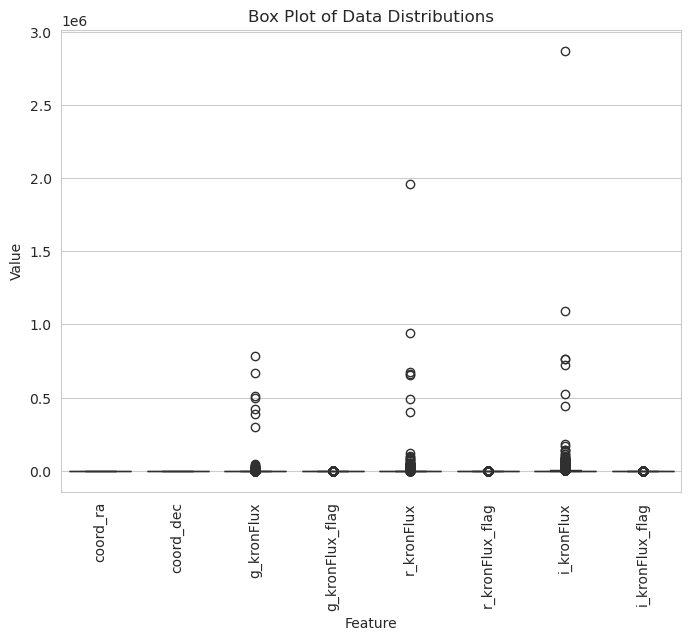

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=results)
plt.title('Box Plot of Data Distributions')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.show()

> A boxplot of the following columns: `coord_ra`, `coord_dec`, `g_kronFlux`, `g_kronflux_flag`, `r_kronFlux`, `r_kronFlux_flag`, `i_kronFlux`, and `i_kronFlux_flag`. The scaling only allows us to see the outlier circles for all of these columns, not the actual boxplot. This will need to be rescaled.

The outliers (points far from the majority of the distribution) are dominant in the visualization. Hide these and also only plot the Kron Flux values.

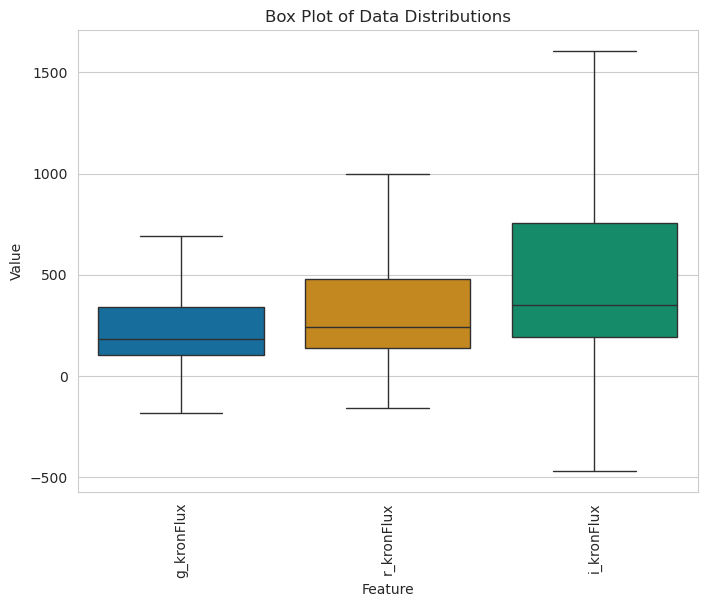

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=results[['g_kronFlux','r_kronFlux','i_kronFlux']], showfliers=False)
plt.title('Box Plot of Data Distributions')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.show()

> A boxplot of the following columns: `g_kronFlux`, `r_kronFlux`, and `i_kronFlux`. The boxplots have greater weight to lower values (<1000), with the whiskers extending for all columns to negative values.

Boxplots show a box and whiskers.
- The "box" is the interquartile range (IQR), which is the 25th percentile of the distribution of a value to the 75th percentile.
- The horizontal line inside the box is the median of the distribution.
- The whisker extends from the IQR to 1.5*IQR away from the edge of the box.
- Points outside the whisker are considered outliers (hidden here).


Use `seaborn`'s violinplot tool to visualize the distribution for these same Kron flux values.

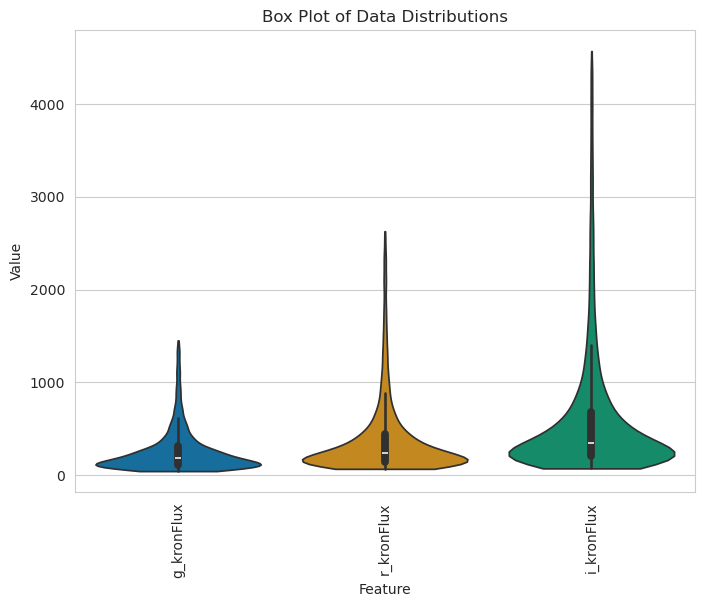

In [14]:
plt.figure(figsize=(8, 6))
filtered_results = results[['g_kronFlux', 'r_kronFlux', 'i_kronFlux']].apply(lambda x: x[(x > x.quantile(0.05)) & (x < x.quantile(0.95))])
sns.violinplot(data=filtered_results,
              cut=0)
plt.title('Box Plot of Data Distributions')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.show()

> A violinplot of the following columns: `g_kronFlux`, `r_kronFlux`, and `i_kronFlux`. The violinplots have greater weight to lower values (<1000), and also include boxplots inside.

A violinplot gives a lot of the same information as a boxplot, in fact, there are little boxplots within the violinplot; the horizontal white line is the median, the thicker grey box is the IQR and the thin line shows the 1.5*IQR span. A violinplot also uses a kernel density extimator to visualize the distribution of each feature. These plots reveal that most of the data are clustered around relatively low values for all of the Kron fluxes.

# 5. Clean the data

Use `pandas` to investigate if there are any flags on the `kronFlux` measurement. The `.value_counts()` method will show the number of True and False columns, where True are rows for which the `g_kronFlux` measurement was flagged for a variety of reasons. There are many other columns that investigate specific reasons why this measurement is untrustworthy; the `g_kronFlux_flag` is a way to combine all of the individual flags. When this flag is set to `True`, the row is flagged.

In [15]:
results['g_kronFlux_flag'].value_counts()

g_kronFlux_flag
False    10728
True       836
Name: count, dtype: int64

Okay what about the `r_kronFlux` measurement?

In [16]:
results['r_kronFlux_flag'].value_counts()

r_kronFlux_flag
False    10723
True       841
Name: count, dtype: int64

Perform an intersection to see if the flagged entries overlap between these two photometric bands.

In [17]:
r_values = set(results['r_kronFlux_flag'].unique())
g_values = set(results['g_kronFlux_flag'].unique())

overlap = r_values & g_values

overlap_true_rows = results[
    (results['r_kronFlux_flag'].isin(overlap)) & 
    (results['g_kronFlux_flag'].isin(overlap)) & 
    (results['r_kronFlux_flag'] == True) & 
    (results['g_kronFlux_flag'] == True)
]

print(overlap_true_rows)

        coord_ra  coord_dec  g_kronFlux  g_kronFlux_flag  r_kronFlux  \
0      62.018897 -37.095671   71.568352             True   91.185588   
12     62.020649 -37.085250  164.458389             True   83.719543   
44     62.050118 -37.076587   90.446302             True  127.674283   
...          ...        ...         ...              ...         ...   
11539  61.964568 -36.904478         NaN             True  414.809809   
11547  61.885858 -36.962398   51.079756             True  138.740430   
11560  61.975756 -36.903597   66.317754             True  114.603682   

       r_kronFlux_flag  i_kronFlux  i_kronFlux_flag  
0                 True  624.454022             True  
12                True   39.636459             True  
44                True  455.773111             True  
...                ...         ...              ...  
11539             True   85.175780            False  
11547             True         NaN             True  
11560             True  199.928482           

There are many overlapping rows, meaning that in these cases, both photometric bands are flagged. Since the task at hand is a prediction one between three bands ($g$, $r$, and $i$) the bigger concern is the cases where any of these individual three Kron fluxes are flagged. Exclude rows where this is the case and build an "unflagged" DataFrame.

In [18]:
unflagged_df = results[
    (results['r_kronFlux_flag'] == False) & 
    (results['g_kronFlux_flag'] == False) &
    (results['i_kronFlux_flag'] == False)
]

Visualize the relationship between $g$ and $r$ in this unflagged DataFrame.

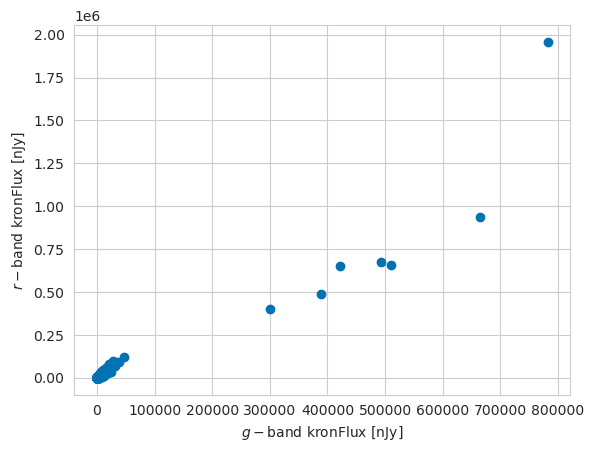

In [19]:
plt.scatter(unflagged_df['g_kronFlux'], unflagged_df['r_kronFlux'])
plt.xlabel(r'$g-$band kronFlux [nJy]')
plt.ylabel(r'$r-$band kronFlux [nJy]');

> Scatter plot of $g-$gand kronFlux [nJy] (x-axis) versus $r-$band kronFlux [nJy] (y-axis). The blue points appear to be roungly linear in this space with more concentration towards lower values and spread at higher values. The few points at high value have values on order 1e6 and there is a concentration around values less than 0.5e5 (in both axes).

Zoom in.

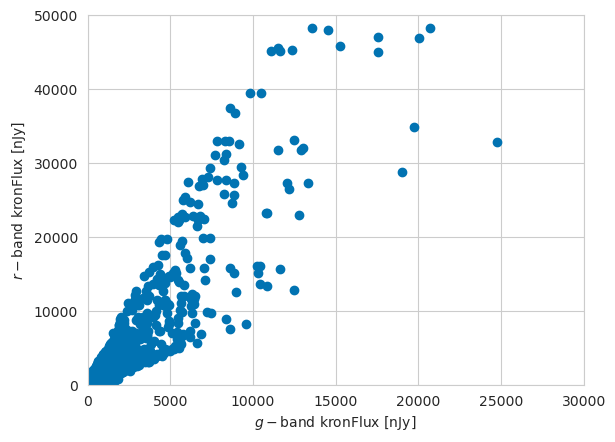

In [20]:
plt.scatter(unflagged_df['g_kronFlux'], unflagged_df['r_kronFlux'])
plt.xlabel(r'$g-$band kronFlux [nJy]')
plt.ylabel(r'$r-$band kronFlux [nJy]')
plt.xlim([0,30000])
plt.ylim([0,0.5e5]);

> Scatter plot of $g-$gand kronFlux [nJy] (x-axis) versus $r-$band kronFlux [nJy] (y-axis). The blue points appear to be roungly linear in this space with more concentration towards lower values and spread at higher values.

There does seem to be a relationship between $g-$ and $r-$band Kron fluxes, meaning that it should be possible to do some predictive work here.

Another thing to check before starting to fit is if there are any nans in these Series. (A Series is a single column of a DataFrame.)

In [21]:
print(unflagged_df['g_kronFlux'].isna().any(), unflagged_df['r_kronFlux'].isna().any())

False False


Both outputs should be `False`.

Another important step is to check for negative (or zero) values in these data; they are fluxes so they should not be negative or equal to zero. First, count the number of these values in each of the $g-$ and $r-$band Series.

In [22]:
neg_g = (unflagged_df['g_kronFlux'] <= 0).sum()
neg_r = (unflagged_df['r_kronFlux'] <= 0).sum()

print(f"Negative or zero values in g_kronFlux: {neg_g}")
print(f"Negative or zero values in r_kronFlux: {neg_r}")

Negative or zero values in g_kronFlux: 23
Negative or zero values in r_kronFlux: 12


Uh oh! This is a big problem, let's mask all rows of the dataframe where any individual flux measurement is negative, making a "clean" DataFrame.

In [23]:
mask = (unflagged_df['g_kronFlux'] > 0) & (unflagged_df['r_kronFlux'] > 0) & (unflagged_df['i_kronFlux'] > 0)
clean_df = unflagged_df[mask]

It's always good to double check if the above mask worked. Below, there should be zero values in the `clean_df`.

In [24]:
neg_g = (clean_df['g_kronFlux'] <= 0).sum()
neg_r = (clean_df['r_kronFlux'] <= 0).sum()
print(f"Negative or zero values in g_kronFlux: {neg_g}")
print(f"Negative or zero values in r_kronFlux: {neg_r}")

Negative or zero values in g_kronFlux: 0
Negative or zero values in r_kronFlux: 0


# 6. Prepare the training and test sets
The goal is to predict the $r-$band Kron flux using the $g-$band Kron flux. The first step is to define the training and validation data.

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    clean_df['g_kronFlux'].to_frame(),
    clean_df['r_kronFlux'].to_frame(),
    test_size=0.2, random_state=42)

The `.to_frame()` argument is required to input the X data as a 2D shape, as expected by `scikit-learn`.

It's best practice to use a standard scaler when training machine learning models. Transform the training and test data, scaling to a mean of zero and a standard deviation of one by default.

**Note to future developer of this notebook: I (Becky) was wondering if a log transform is also necessary because the data seems logarithmically scaled. I'm not sure if it's needed, but I've set this up to also include an invertible log transform if you want to test it.**

In [74]:
log_scaler = FunctionTransformer(func=np.log, inverse_func=np.exp, validate=True)

X_scaler = make_pipeline(
    #log_scaler,
    StandardScaler()
)

y_scaler = make_pipeline(
    #log_scaler,
    StandardScaler()
)

Fit to the transform and then also transform the test data according to the scaler.

In [75]:
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

Check that the resultant distribution for training data has a center of roughly zero.

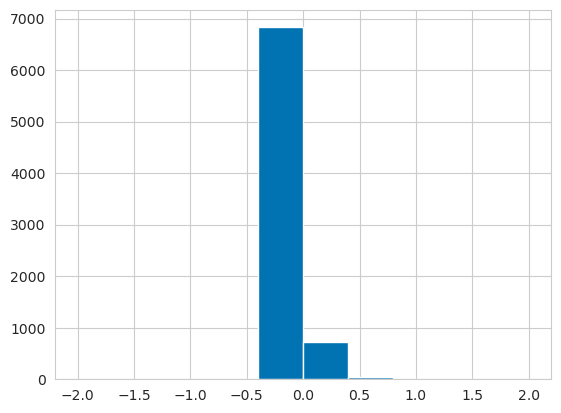

In [76]:
plt.clf()
plt.hist(X_train_scaled, range=[-2,2]);

> A histogram with a x-axis range from -2 to 2 for the distribution of the rescaled `X_train` data.

Perform the inverse transform to check if the twice transformed data is the same as the original.

In [77]:
X_train_tt = X_scaler.inverse_transform(X_train_scaled)
X_test_tt = X_scaler.inverse_transform(X_test_scaled)

y_train_tt = y_scaler.inverse_transform(y_train_scaled)
y_test_tt = y_scaler.inverse_transform(y_test_scaled)

Check that the original `X_train` is the same as the twice transformed `X_train_tt`.

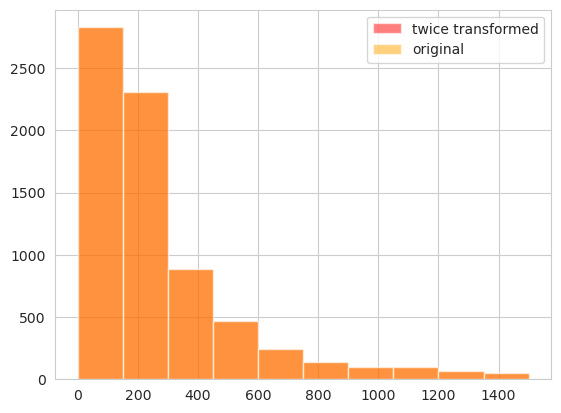

In [78]:
plt.clf()
plt.hist(X_train_tt, range=[0,1500], label='twice transformed', alpha=0.5, color='red')
plt.hist(X_train, range=[0,1500], label='original', alpha=0.5, color='orange')
plt.legend();

> Overlapping histograms for `X_train` and `X_train_tt` with an x-axis range of 0 to 1500.

# 7. Model (using `scikit-learn`)

## 7.1 Start with a linear regression

Instantiate the model and then fit it with the training data.

In [79]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

LinearRegression()

Now predict the test data. Compare the prediction to the true value. Use the mean squared error function to get a diagnostic on how well the fit is behaving for the test set.

In [80]:
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test_scaled, y_pred)
print("MSE:", mse)

MSE: 0.10849655661786743


Plot how the predicted values compare to the true values.

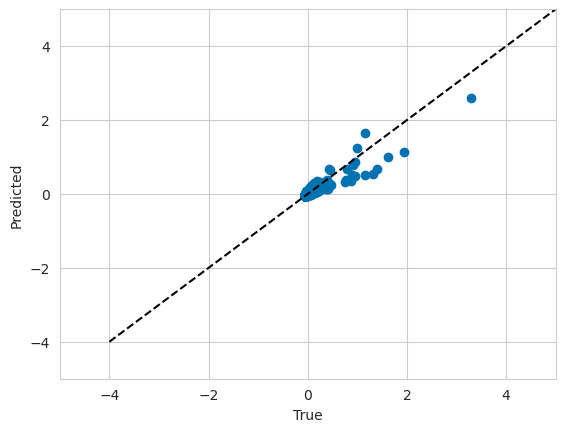

In [82]:
plt.clf()
plt.scatter(y_test_scaled, y_pred)
plt.plot([-4,6],[-4,6], color='black', ls='--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.xlim([-5,5])
plt.ylim([-5,5]);

> Scatter plot of true versus predicted value for the scaled $r-$band Kron flux. A 1:1 line shows the expected value if the linear regression were a perfect predictor.

Transform the predictions back to the true values (remember the current scaling is standardized) and look at the results in that space.

In [83]:
y_pred_tt = y_scaler.inverse_transform(y_pred)

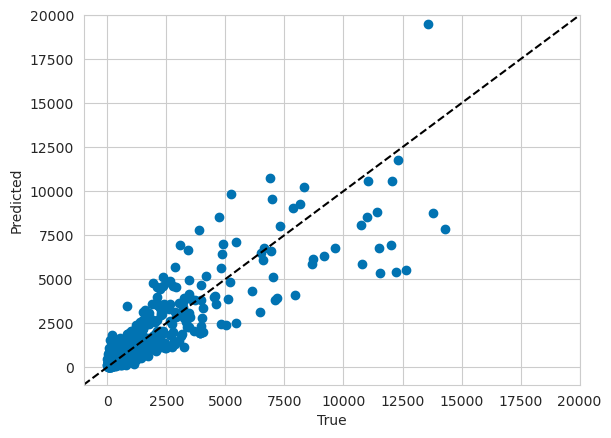

In [89]:
plt.clf()
plt.scatter(y_test_tt, y_pred_tt)
plt.plot([-1e3,2e4],[-1e3,2e4], color='black', ls='--')
plt.xlabel('True')
plt.ylabel('Predicted');
plt.xlim([-1e3,2e4])
plt.ylim([-1e3,2e4]);

> A scatterplot of the true versus predicted value for the $r-$band Kron flux scaled back to the original values. tHe x- and y-axes scale between -1000 to 2e4.

Also get the MSE for the rescaled y value.

In [93]:
mse = mean_squared_error(y_test_tt, y_pred_tt)
print("MSE:", mse)

MSE: 80347168.49722074


## 7.2 Improve the model with more features
Let's see if this will improve with more predictive values, this time including the $i-$band Kron flux. Split the training/test sets, perform the standard scaling, and linear regression. This time, do not scale the y-value $r-$band Kron flux.

MSE: 252763.24546072097


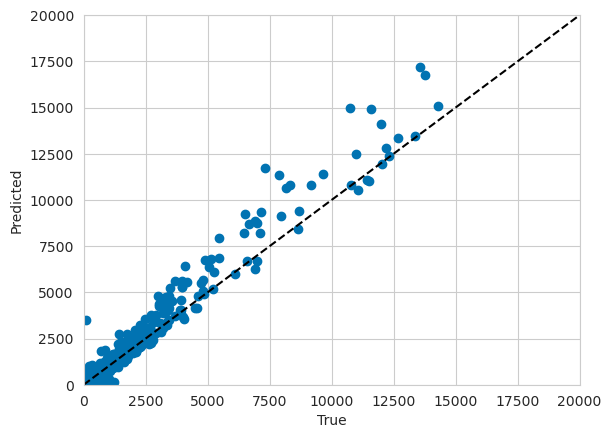

In [99]:
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    clean_df[['g_kronFlux', 'i_kronFlux']],  # Use these two features
    clean_df['r_kronFlux'],                 # Target variable
    test_size=0.2,
    random_state=42
)

scaler = StandardScaler()
X_train_i_scaled = scaler.fit_transform(X_train_i)
X_test_i_scaled = scaler.transform(X_test_i)

model = LinearRegression()
model.fit(X_train_i_scaled, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

plt.clf()
plt.scatter(y_test, y_pred)
plt.plot([0, 1e6], [0, 1e6], color='black', ls='--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.xlim([0, 2e4])
plt.ylim([0, 2e4])
plt.show()

> A scatter plot demonstrating a tighter fit when the $i-$band Kron flux is included as a predictive feature.

Test for the reader: try to improve this further by including more features. The MSE has already improved from the above value!

## 7.3 Random forest regressor
These are a great type of model for regression or classification. Use it here to perform regression, again, also including the $i-$band Kron fluxes.

MSE: 252763.24546072097


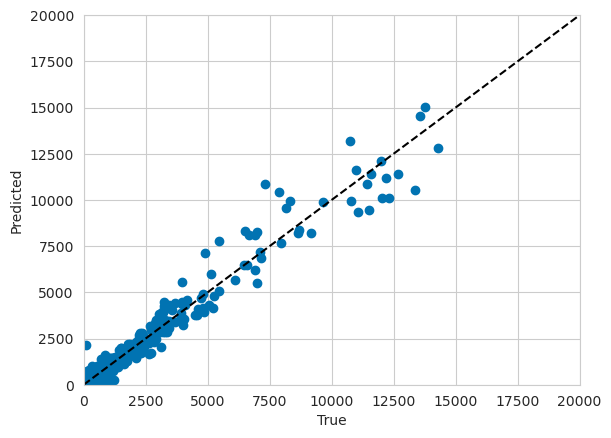

In [101]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train_i_scaled, y_train_i)

y_pred_i = model_rf.predict(X_test_i_scaled)


mse = mean_squared_error(y_test_i, y_pred)
print("MSE:", mse)

plt.clf()
plt.scatter(y_test_i, y_pred_i)
plt.plot([0, 1e6], [0, 1e6], color='black', ls='--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.xlim([0, 2e4])
plt.ylim([0, 2e4]);

> Another scatterplot of true versus predicted y-values.

**Strange that the MSE is exactly the same?**

# 8. Hyperparameter tuning
With any `scikit-learn` model, it's possible to tune the hyperparameters to achieve better performance. Define the grid to search over, here test the `n_estimators` parameter from random forest estimators, which defines the number of trees in the random forest. The default setting is 100.

In [102]:
param_grid = {'n_estimators': [1, 10, 50, 100, 200, 1000, 10000]}

Now define the `GridSearchCV` object and fit the model, wrapped in this grid search object.

In [ ]:
grid = GridSearchCV(model, param_grid, cv=5)

grid.fit(X_train_i_scaled, y_train_i)

print(grid.best_params_)

Now retrieve the best model and print out model diagnostics.

In [ ]:
best_model = grid.best_estimator_
print("Best Model:", best_model)
y_pred_grid = best_model.predict(X_test_i_scaled)
plt.clf()
plt.scatter(y_test_i, y_pred_grid)
plt.plot([0, 1e6], [0, 1e6], color='black', ls='--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.xlim([0, 2e4])
plt.ylim([0, 2e4])
plt.show()

mse = mean_squared_error(y_test_i, y_pred_grid)
print("MSE:", mse)

# 9. Fit the best model to rows where the $r-$band Kron flux is missing.

First, return to the dataframe and snag rows where the $r-$band flux is flagged but the $g-$ and $i-$band Kron fluxes are intact.

In [105]:
r_missing_df = results[
    (results['r_kronFlux_flag'] == True) & 
    (results['g_kronFlux_flag'] == False) &
    (results['i_kronFlux_flag'] == False)
]
r_missing_df

,coord_ra,coord_dec,g_kronFlux,g_kronFlux_flag,r_kronFlux,r_kronFlux_flag,i_kronFlux,i_kronFlux_flag
10,62.010663,-37.088064,303.684022,False,232.540549,True,310.371904,False
22,62.006350,-37.090115,58.774248,False,135.041368,True,305.676263,False
41,62.014721,-37.080369,317.485708,False,450.916090,True,134.658024,False
...,...,...,...,...,...,...,...,...
11461,61.882326,-36.990083,310.036393,False,250.901590,True,228.085994,False
11475,61.924031,-36.998350,104.742902,False,110.345845,True,262.059423,False
11559,61.935633,-36.950795,495.811802,False,128.753038,True,218.522159,False


In [106]:
X_r_missing = r_missing_df[['g_kronFlux', 'i_kronFlux']]
X_r_missing_scaled = scaler.fit_transform(X_r_missing)
y_pred_r_missing = best_model.predict(X_r_missing_scaled)

NameError: name 'best_model' is not defined

In [ ]:
plt.scatter(r_missing_df['r_kronFlux'].values, y_pred_r_missing)
plt.xlabel(r'Flagged $r-$band values')
plt.ylabel('Predicted $r-$band values');

# 10. Other available `scikit-learn` choices
The below two cells explore available options from `scikit-learn` for regression metrics and regression models, respectively. The metric cell is truncated with a `break` statement to only print details of the first metric. The model cell demonstrates printing the class information for the `RandomForestRegressor` class.

In [ ]:
regression_metrics = [
    name for name, obj in inspect.getmembers(metrics)
    if inspect.isfunction(obj)
    and ('regression' in (obj.__doc__ or '').lower() or 'error' in (obj.__doc__ or '').lower())
    and 'classification' not in (obj.__doc__ or '').lower()
]
print(regression_metrics)


# Print the filtered metrics and their documentation
for metric in regression_metrics:
    metric_func = getattr(metrics, metric)
    if metric == "mean_tweedie_deviance":
        print(f"--- {metric} ---")
        help(metric_func)
        print("="*80)

In [ ]:
# Get all regression models
regressors = all_estimators(type_filter='regressor')

# Print the names of all available regression models
for name, estimator in regressors:
    print(name)

for name, estimator in regressors:
    if name == "RandomForestRegressor":
        print(help(estimator))

# Exercise for the learner

The uncertainty values are also available for each column of Kron fluxes. Use those to run an uncertainty-aware model fit for the $r-$band Kron fluxes.